Data source: https://www.kaggle.com/datasets/jonathanbesomi/superheroes-nlp-dataset

Note that I did some of the data cleaning in Excel before importing the file into the Python project, so you need to load the Excel file provided, as the one downloaded directly from Kaggle won't be properly cleaned by the code below, as I wrote the code specifically for the already partially cleaned version of the data.

To be specific as to how I modified the Excel file prior to importing it:
In no particular order,
1. I filled in many of the missing values in the gender column, specifically the ones where the name made the gender
   obvious and/or I was familiar with the character
2. I filled in some of the missing values for race and alignment, going by either personal knowledge of particular
   characters, or by Googling the character
3. Similarly for the creator column
4. I replaced both the cells containing only "-" and the empty cells with cells containing "NaN".
5. I put both the weight and height data into common units, i.e. I converted any meter measurements to cm and any ton measurements to kg.
6. I deleted several of the rows that randomly contained character descriptions and no variable values, as well as empty
   rows
7. I deleted a few rows that contained very little information (i.e. most of the cells were blank)
8. A few of the columns had a few values with differing capitalization (e.g. "blue" vs "Blue" in the eye color column) and I used Excel's "Search and Replace" function  to give them the same capitalization

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None

from pandas_profiling import ProfileReport

import numpy as np
import sklearn as sk
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%load_ext rpy2.ipython


In [462]:
%%R
library(dplyr)
library(ggplot2)

library(e1071)
library(caTools)
library(class)
library(caret)

R[write to console]: Error: package or namespace load failed for 'caret' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace 'lifecycle' 1.0.1 is already loaded, but >= 1.0.3 is required

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'caret' was built under R version 4.2.2 




Error: package or namespace load failed for 'caret' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace 'lifecycle' 1.0.1 is already loaded, but >= 1.0.3 is required


RInterpreterError: Failed to parse and evaluate line 'library(dplyr)\nlibrary(ggplot2)\n\nlibrary(e1071)\nlibrary(caTools)\nlibrary(class)\nlibrary(caret)\n'.
R error message: "Error: package or namespace load failed for 'caret' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):\n namespace 'lifecycle' 1.0.1 is already loaded, but >= 1.0.3 is required"

Read in and clean data

In [385]:
dropRows = [55, 76, 78, 81, 410, 481, 486, 490, 645, 653, 657, 693,
            697, 840, 827, 830, 842, 844, 949, 950, 1059, 1063, 1077, 1079, 1081]
#original data set had nonsense rows

superheroData = \
    pd.read_excel("Superhero data.xlsx").\
    drop(dropRows).\
    drop(["full_name"], axis = 1).\
    dropna(how = "all").\
    reset_index()#.\
    #drop(["index"], axis = 1)

#Fix format of height and weight variables:
columnLength = 1408

for i in range(0, columnLength-1): #final row already has data in the correct form
        #height data is of the form "6'8 â€¢ 203 cm" which would be very difficult to work with
        #hence I'm extracting just the value in centimeters and converting to a float
        #similar for weight

        if not(str(superheroData["height"][i]) == "nan"):
            try:
                superheroData["height"][i] = float(str(superheroData["height"][i]).split()[2]) #noqa
            except:
                superheroData["height"][i] = \
                    str(superheroData.iloc[:,("height", i)]).replace(',', '') #noqa
                superheroData["height"][i] = float(superheroData["height"][i].split()[2]) #noqa

        if not(str(superheroData["weight"][i]) == "nan"):
            try:
                superheroData["weight"][i] = float(str(superheroData["weight"][i]).split()[3]) #noqa
            except:
                superheroData["weight"][i] = str(superheroData["weight"][i]).replace(',', '') #noqa
                superheroData["weight"][i] = float(superheroData["weight"][i].split()[3]) #noqa

superheroData;

Check for and impute missing data values:

In [305]:
superheroData.isnull().sum();

In [386]:
quantitativeVariables = superheroData.iloc[:, [3, 4, 5, 6, 7, 8, 14, 15]]

knnImputer = KNNImputer(n_neighbors = 10)

quantitativeVariablesFilled = \
    pd.DataFrame(knnImputer.fit_transform(quantitativeVariables)).\
    rename(columns = {0:"intelligence score", 1:"strength score",
                      2:"speed score", 3:"durability score",
                      4:"power score", 5: "combat score",
                      6:"height (cm)", 7:"weight (kg)" })

quantitativeVariablesFilled;

In [387]:
categoricalVariableNames = [i for i in range(16, 68)]

categoricalVariables = superheroData.iloc[:, [1, 2, 9, 10, 11, 12, 13] + categoricalVariableNames]

simpleImputer = SimpleImputer(strategy = "most_frequent")

categoricalVariablesFilled = pd.DataFrame(simpleImputer.fit_transform(categoricalVariables))

categoricalVariablesFilled.columns = categoricalVariables.columns

categoricalVariablesFilled;

In [388]:
superheroDataFilled = pd.concat([categoricalVariablesFilled, quantitativeVariablesFilled], axis = 1)
superheroDataFilled.head();

Explore data:

In [389]:
%%R -i superheroDataFilled -o creatorNamesandCounts

# noinspection PyUnreachableCode
GetNamesandCounts = function(x, variable = 0, variable_name = 0)
{
    Counts = x %>% table() %>% as.vector()

    Names = x %>% unique() %>% unlist() %>% sort()

    if(variable == 0 & variable_name == 0)
	{
        NamesandCounts = data.frame(Names, Counts) %>% setNames(c('creator names', 'creator counts'))
	}

    else
	{
        NamesandCounts = data.frame(Names, Counts) %>% setNames(c(paste0(variable_name, ' names'), paste0(variable_name, ' counts')))
    }
    return(NamesandCounts)
}


creatorNamesandCounts = GetNamesandCounts(superheroDataFilled['creator'])

In [390]:
creatorsBarChart = px.bar(creatorNamesandCounts, x = 'creator names', y = 'creator counts')
creatorsBarChart;

Since, as the above bar graph shows, the vast majority characters in the data set are from the top 6 creators, the others are unlikely to contribute
meaningfully to the overall patterns and will only complicate the analysis, hence I'll remove them and create a new graph:

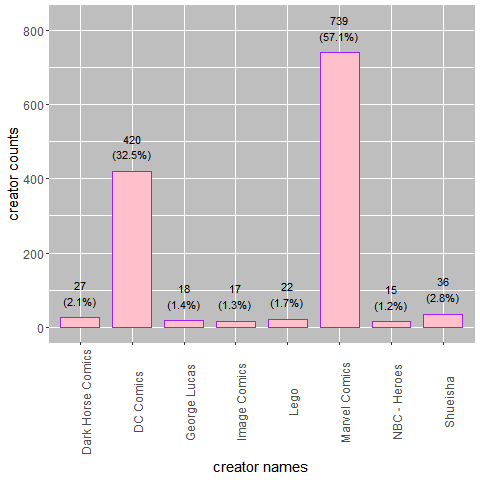

In [391]:
%%R -o superheroData_removed_infrequent_creators

superheroData_removed_infrequent_creators =
superheroDataFilled %>% filter(creator %in% c('Marvel Comics','DC Comics', 'Shueisha', 'Lego', 'Image Comics',
                                              'George Lucas', 'Dark Horse Comics', 'NBC - Heroes'))

creatorNamesandCounts = GetNamesandCounts(superheroData_removed_infrequent_creators['creator'])


#create labels for new graph
labels = function(x)
{
    labels = unlist(round((x/sum(x))*100, 1)) %>% as.vector

    for(i in 1:length(labels))
    {
      labels[i] = paste0(toString(unlist(x)[i]), '\n(', labels[i], '%', ')' )
    }

    labels
}

labels = labels(creatorNamesandCounts['creator counts'])

ggplot(creatorNamesandCounts, aes(`creator names`, `creator counts`, label = labels)) +
       geom_bar(stat = "identity", fill = 'pink', color = "purple", width = 0.75) +
       theme(text = element_text(size=15), axis.text.x = element_text(angle = 90), panel.background = element_rect(fill = 'grey', color = 'grey')) +
       geom_text( vjust = -0.5, label.size = 0.15) +
       scale_y_continuous(limits = c(0, 825))



Further explore data, looking for outliers to remove (where I'm defining an outlier as a value whose relative frequency in its column is less than 1%)

In [392]:
%%R -i categoricalVariablesFilled -o categoricalVariableNames

summaryTable = list()

categoricalVariableNames = categoricalVariablesFilled %>% colnames

for(i in 4:length(categoricalVariableNames))
{
    summaryTable[[i-3]] = superheroData_removed_infrequent_creators[paste0(categoricalVariableNames[i])] %>% table
}


In [393]:
%%R -o summaryTable
summaryTable

[[1]]
creator
Dark Horse Comics         DC Comics      George Lucas      Image Comics 
               27               420                18                17 
             Lego     Marvel Comics      NBC - Heroes          Shueisha 
               22               739                15                36 

[[2]]
alignment
    Bad    Good Neutral 
    416     764     114 

[[3]]
gender
Female   Male   None 
   335    957      2 

[[4]]
type_race
                   Alien                   Amazon                  Android 
                      30                        5                       18 
                  Animal                Asgardian                Atlantean 
                      24                       16                       10 
                 Bizarro               Bolovaxian               Centaurian 
                       2                        1                        1 
                   Clone            Cosmic Entity                   Cyborg 
                    

In [394]:
%%R -o superheroDataFiltered

superheroDataFiltered = superheroData_removed_infrequent_creators %>% subset(gender != 'None'  )

In [ ]:
ProfileReport(superheroDataFiltered)

In [395]:
%%R -o filteredNamesAndCounts

GetRaceEyeAndHairNameandCounts = function(df)
{
    raceNamesandCounts = GetNamesandCounts(df['type_race'], 'type_race', 'race')

    eyeColorNameandCounts = GetNamesandCounts(df['eye_color'], 'eye_color', 'eye color')

    hairColorNameandCounts = GetNamesandCounts(df['hair_color'], 'hair_color', 'hair color')

# noinspection PyArgumentList, PyRedundantParentheses
    return(list(raceNamesandCounts = raceNamesandCounts, eyeColorNameandCounts = eyeColorNameandCounts, hairColorNameandCounts = hairColorNameandCounts))

}

filteredNamesAndCounts = GetRaceEyeAndHairNameandCounts(superheroDataFiltered)

In [396]:
def PlotRaceEyeAndHairNameandCounts(df):
    px.bar(df['raceNamesandCounts'], x ='race names', y ='race counts').show()
    px.bar(df['eyeColorNameandCounts'], x ='eye color names', y ='eye color counts').show()
    px.bar(df['hairColorNameandCounts'], x ='hair color names', y ='hair color counts').show()

PlotRaceEyeAndHairNameandCounts(filteredNamesAndCounts)

In [397]:
%%R -o superheroDataFiltered

superheroDataFiltered =
superheroDataFiltered %>% filter(type_race %in% c('Human', 'Mutant', 'Metahuman', 'God/Eternal',
                                              'Alien ', 'Animal', 'Asgardian', 'Android', 'Cyborg','Human/Radiation')) %>%
                        filter(eye_color %in% c('Blue', 'Black', 'Brown', 'Green', 'Red', 'White', 'Yellow')) %>%
                        filter(hair_color %in% c('Black', 'Blond', 'Brown', 'No Hair', 'Red', 'White', 'Grey', 'Green',
                                                'Strawberry', 'Auburn'))


In [ ]:
ProfileReport(superheroDataFiltered)

Only Top Two Creators

In [398]:
%%R -o OnlyTop2Creators

OnlyTop2Creators  = superheroDataFilled %>% filter(creator %in% c('Marvel Comics','DC Comics'))

Top two creators filtered data

In [399]:
%%R -o Top2CreatorNamesAndCounts
Top2CreatorNamesAndCounts = GetRaceEyeAndHairNameandCounts(OnlyTop2Creators)

In [400]:
PlotRaceEyeAndHairNameandCounts(Top2CreatorNamesAndCounts)

In [401]:
%%R -o Top2CreatorsFiltered

Top2CreatorsFiltered = OnlyTop2Creators %>% filter(type_race %in% c('Human', 'Mutant', 'Metahuman', 'Inhuman', 'God/Eternal',
                                                                    'Human/Radiation', 'Alien ', 'Animal', 'Asgardian', 'Android',
                                                                    'Cyborg','Human/Radiation')) %>%
                        filter(eye_color %in% c('Blue', 'Black', 'Brown', 'Green', 'Red', 'White', 'Yellow')) %>%
                        filter(hair_color %in% c('Black', 'Blond', 'Brown', 'No Hair', 'Red', 'White', 'Grey', 'Green',
                                                'Strawberry', 'Auburn', 'Strawberry Blond'))

In [402]:
%%R -o Top2CreatorsFilteredNamesAndCounts
Top2CreatorsFilteredNamesAndCounts = GetRaceEyeAndHairNameandCounts(Top2CreatorsFiltered)

In [ ]:
PlotRaceEyeAndHairNameandCounts(Top2CreatorsFilteredNamesAndCounts)

KNN Classification: Sort Values by Creator

Helper functions:

In [403]:
%%R

ifmissing = function(x, value)
{
    if(missing(x))
      return(value)
    else
        return(x)
}

KNN_SetUp = function(df, categoryColumn, splitRatio, quantitativeVariableColumns)
{
  #do train/test split for initial model
  split = sample.split(categoryColumn, SplitRatio = 0.7)

  training_set = subset(df, split == TRUE)
  test_set = subset(df, split == FALSE)

  #scale quantitative variables to similar ranges
  train_scale = scale(training_set[, quantitativeVariableColumns])
  test_scale = scale(test_set[, quantitativeVariableColumns])

  return(list(train_scale, test_scale, training_set, test_set, split))
}


Main function

In [438]:
%%R -o temp

KNN_Analysis = function(df, category, categoryColumn, initialSplitRatio, quantitativeVariableColumns, starting_k)
{

  initialSplitRatio = ifmissing(initialSplitRatio, 0.75)

  quantitativeVariableColumns = ifmissing(quantitativeVariableColumns, 10:67)

  starting_k = ifmissing(starting_k, 5)

  set.seed(123)

  temp = KNN_SetUp(df = df, categoryColumn = categoryColumn, splitRatio = initialSplitRatio,
                   quantitativeVariableColumns = quantitativeVariableColumns)
  train_scale <- temp[[1]]
  test_scale = temp[[2]]
  training_set <- temp[[3]]
  test_set = temp[[4]]

  #find best k
  out_of_sample_error_k = c()
  in_sample_error_k = c()

  knnModels_VaryingK = vector(mode = 'list', length = 67)

  for(k in c(1:56))
  {
    classifier_knn <- knn(train = train_scale,
                          test = test_scale,
                          cl <- training_set$creator,
                          k = k)
    out_of_sample_error_k[k] = mean(classifier_knn != test_set$creator)
    #in_sample_error_k[k] = mean(classifier_knn != training_set$creator)

    knnModels_VaryingK[[k]] = classifier_knn
  }

  best_k = which.min(out_of_sample_error_k)

  #find best split ratio
  outOfSampleErrorSplitRatio = c()
  InSampleErrorSplitRatio = c()

  knnModels_VarySplitRatio = vector(mode = 'list', length = 99)

  skippedRatios = c()
  skippedRatioCount = 0

  for(i in 1:99)
  {
    temp = KNN_SetUp(df = df, categoryColumn = categoryColumn, splitRatio = i/100,
                     quantitativeVariableColumns = quantitativeVariableColumns)
    train_scale = temp[[1]]
    test_scale = temp[[2]]
    training_set <- temp[[3]]
    test_set = temp[[4]]

    if(train_scale %>% is.na %>% sum == 0 & test_scale %>% is.na %>% sum == 0)
    {
      classifier_knn = knn(train = train_scale,
                            test = test_scale,
                            cl = training_set$creator,
                            k = best_k)

      outOfSampleErrorSplitRatio[i] = mean(classifier_knn != test_set$creator)
      #InSampleErrorSplitRatio[i] = mean(classifier_knn != training_set$creator)
      knnModels_VarySplitRatio[[i]] = classifier_knn
    }

    else
    {
      skippedRatioCount = skippedRatioCount + 1
      skippedRatios[skippedRatioCount] = i/100
    }

  }

# noinspection PyRedundantParentheses
  if(skippedRatioCount == 0)#:
  {
    skippedRatios = "no skipped ratios"
  }

  bestSplitRatio = which.min(outOfSampleErrorSplitRatio)/100

  best_model = knnModels_VarySplitRatio[[bestSplitRatio*100]]

  confusionMatrix_bestModel = table(test_set$creator, best_model)

  results = list(out_of_sample_error_k = out_of_sample_error_k, knnModels_VaryingK = knnModels_VaryingK, best_k = best_k,
              outOfSampleErrorSplitRatio = outOfSampleErrorSplitRatio, knnModels_VarySplitRatio = knnModels_VarySplitRatio,
              bestSplitRatio = bestSplitRatio, best_model = best_model, confusionMatrix_bestModel = confusionMatrix_bestModel,
              skippedRatios = skippedRatios, in_sample_error_k = in_sample_error_k, InSampleErrorSplitRatio = InSampleErrorSplitRatio)

  return(list(out_of_sample_error_k = out_of_sample_error_k, knnModels_VaryingK = knnModels_VaryingK, best_k = best_k,
              outOfSampleErrorSplitRatio = outOfSampleErrorSplitRatio, knnModels_VarySplitRatio = knnModels_VarySplitRatio,
              bestSplitRatio = bestSplitRatio, best_model = best_model, confusionMatrix_bestModel = confusionMatrix_bestModel,
              skippedRatios = skippedRatios, in_sample_error_k = in_sample_error_k, InSampleErrorSplitRatio = InSampleErrorSplitRatio,
              train_data = training_set$creator))

}


Analysis on unfiltered data

In [405]:
%%R -o knn_results_unfiltered_data
knn_results_unfiltered_data = KNN_Analysis(superheroDataFilled, categoryColumn = superheroDataFilled$creator, initialSplitRatio = 0.73,
                    quantitativeVariableColumns = 10:67, starting_k = 24)


In [406]:
def Show_KNN_Results(KNN_results, confusionMatrixNames = None): #too many categories for it to be worth displaying the confusion matrix for the full dataset, but worth                                                                 #it for the filtered data set
    bestSplitRatio = KNN_results['bestSplitRatio'][0]
    best_k = KNN_results['best_k'][0]
    outOfSampleErrorSplitRatio = KNN_results['outOfSampleErrorSplitRatio']
    #InSampleErrorSplitRatio = KNN_results['InSampleErrorSplitRatio']
    outOfSampleErrorBestModel = outOfSampleErrorSplitRatio[int(bestSplitRatio * 100) - 1]
    #InSampleErrorBestModel= InSampleErrorSplitRatio[int(bestSplitRatio * 100) - 1]
    skippedRatios = KNN_results['skippedRatios']

    print("".join(["best split ratio = ", str(bestSplitRatio)]))
    print("".join(["best k = ", str(best_k)]))
    print("".join(["out of sample error rate of best model = ", str(round(outOfSampleErrorBestModel * 100, 3)), "%"]))
    #print("".join(["in sample error rate of best model = ", str(round(InSampleErrorBestModel * 100, 3)), "%"]))
    print("skipped ratios:")
    print(skippedRatios)

    if confusionMatrixNames != None:
        confusionMatrix_bestModel = pd.DataFrame(KNN_results['confusionMatrix_bestModel'], columns = confusionMatrixNames, index = confusionMatrixNames)
        print("Confusion Matrix for best model:")
        print(confusionMatrix_bestModel)

Show_KNN_Results(knn_results_unfiltered_data);

best split ratio = 0.37
best k = 7
out of sample error rate of best model = 38.955%
skipped ratios:
[1] "no skipped ratios"



Plot of error of models with varying split ratio and varying value

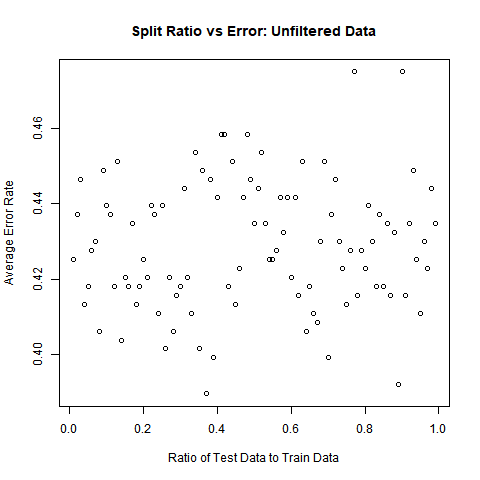

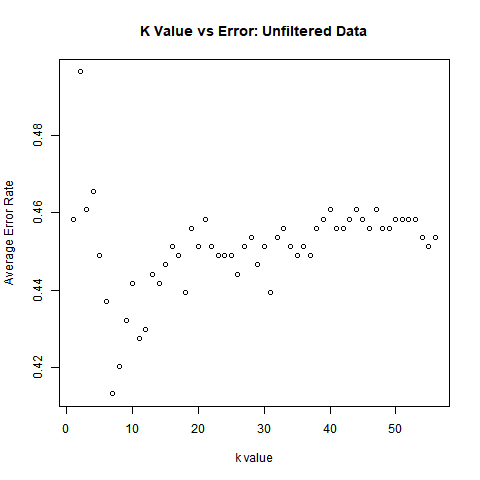

In [430]:
%%R

plotError = function(knn_results, DataName)
{
    plot(x = (1:99)*(1/100), y = knn_results$outOfSampleErrorSplitRatio,
         main = paste0("Split Ratio vs Error: ", DataName), xlab = "Ratio of Test Data to Train Data",
         ylab = "Average Error Rate")

    plot(x = 1:56, y = knn_results$out_of_sample_error_k, main = paste0("K Value vs Error: ", DataName), xlab = "k value", ylab = "Average Error Rate")
}

plotError(knn_results_unfiltered_data, DataName = "Unfiltered Data")


Analysis on data with infrequent creator values removed

In [408]:
%%R -o knn_results_no_infrequent_creators
knn_results_no_infrequent_creators = KNN_Analysis(superheroData_removed_infrequent_creators,
                                                  categoryColumn = superheroData_removed_infrequent_creators$creator,
                                                  initialSplitRatio = 0.73, quantitativeVariableColumns = 10:67,
                                                  starting_k = 24)

In [409]:
%%R -o confusionMatrixNames
confusionMatrixNames = knn_results_no_infrequent_creators[[8]] %>% row.names

In [410]:
Show_KNN_Results(knn_results_no_infrequent_creators, confusionMatrixNames = confusionMatrixNames)

best split ratio = 0.29
best k = 24
out of sample error rate of best model = 39.332%
skipped ratios:
[1] "no skipped ratios"

Confusion Matrix for best model:
                   Dark Horse Comics  DC Comics  George Lucas  Image Comics  \
Dark Horse Comics                  0          1             0             0   
DC Comics                          0         25             0             0   
George Lucas                       0          2             0             0   
Image Comics                       0          2             0             0   
Lego                               0          2             0             0   
Marvel Comics                      0         50             0             0   
NBC - Heroes                       0          1             0             0   
Shueisha                           0          1             0             0   

                   Lego  Marvel Comics  NBC - Heroes  Shueisha  
Dark Horse Comics     0              7             0         0  

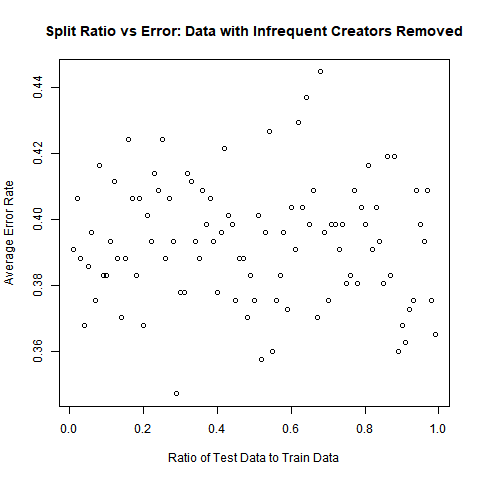

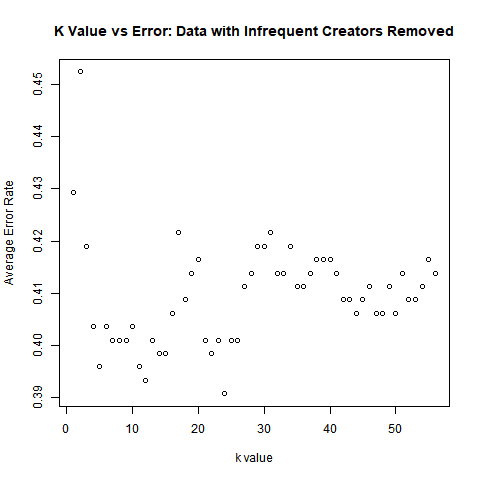

In [431]:
%%R
plotError(knn_results_no_infrequent_creators, DataName = "Data with Infrequent Creators Removed")

Analysis on filtered data


In [418]:
%%R -o knn_results_filtered_data
knn_results_filtered_data = KNN_Analysis(superheroDataFiltered, categoryColumn = superheroDataFiltered$creator, initialSplitRatio = 0.73,
                    quantitativeVariableColumns = 10:67, starting_k = 24)

In [419]:
%%R -o confusionMatrixNames
confusionMatrixNames = knn_results_filtered_data[[8]] %>% row.names

In [420]:
Show_KNN_Results(knn_results_filtered_data, confusionMatrixNames = confusionMatrixNames)

best split ratio = 0.92
best k = 47
out of sample error rate of best model = 35.612%
skipped ratios:
[0.75]
Confusion Matrix for best model:
                   Dark Horse Comics  DC Comics  George Lucas  Image Comics  \
Dark Horse Comics                  0          0             0             0   
DC Comics                          0         20             0             0   
George Lucas                       0          0             0             0   
Image Comics                       0          1             0             0   
Lego                               0          1             0             0   
Marvel Comics                      0         30             0             0   
NBC - Heroes                       0          0             0             0   
Shueisha                           0          1             0             0   

                   Lego  Marvel Comics  NBC - Heroes  Shueisha  
Dark Horse Comics     0              4             0         0  
DC Comics        

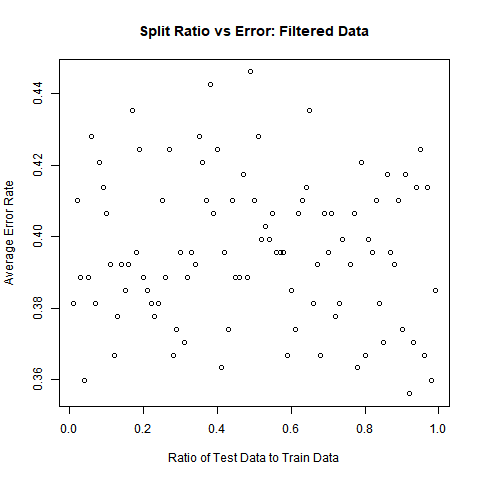

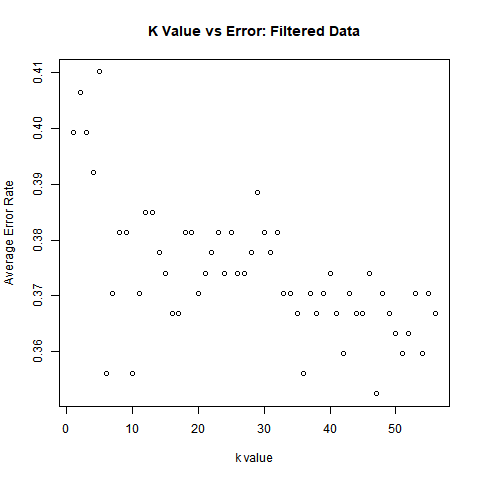

In [432]:
%%R
plotError(knn_results_filtered_data, DataName = "Filtered Data")

Since some of the error seems to come from the model attempting to  classify values into from creators other than the top two (as the top creators categories are SO much more frequent then the others, even having removed all the least frequent ones), let's see how the a KNN model does on data containing only values from the top two categories, first without any of the outliers from the other categorical  other variables removed.  Interestingly, the error rate for the KNN model on the data with all the creators but other outliers removed was actually slightly higher than for the completely unfiltered data, so it'll be interesting to see if that's also the case with the filtered vs unfiltered data below.

In [426]:
%%R -o knn_results_only_2_creators
knn_results_only_2_creators = KNN_Analysis(OnlyTop2Creators, categoryColumn = OnlyTop2Creators$creator, initialSplitRatio = 0.73,
                    quantitativeVariableColumns = 10:67, starting_k = 24)

In [427]:
%%R -o confusionMatrixNames
confusionMatrixNames = knn_results_only_2_creators[[8]] %>% row.names

In [428]:
Show_KNN_Results(knn_results_only_2_creators, confusionMatrixNames = confusionMatrixNames)

best split ratio = 0.34
best k = 13
out of sample error rate of best model = 26.437%
skipped ratios:
[1] "no skipped ratios"

Confusion Matrix for best model:
               DC Comics  Marvel Comics
DC Comics             27             99
Marvel Comics         41            181


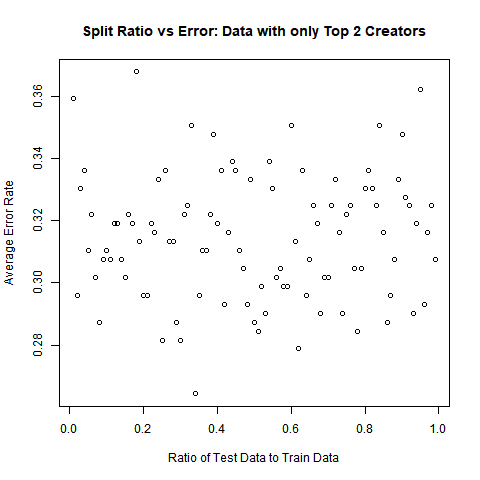

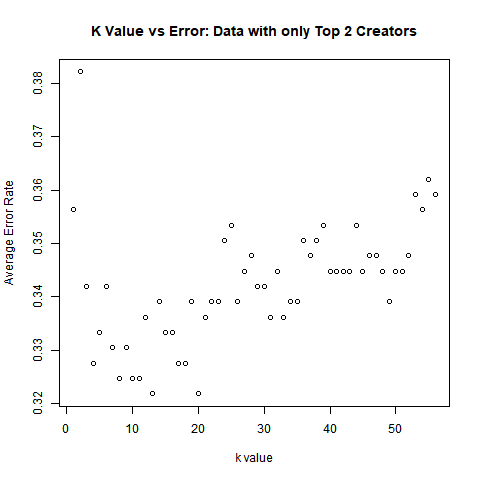

In [433]:
%%R
plotError(knn_results_only_2_creators, DataName = "Data with only Top 2 Creators")

In [439]:
%%R -o knn_results_Top2CreatorsFiltered
knn_results_Top2CreatorsFiltered = KNN_Analysis(Top2CreatorsFiltered, categoryColumn = Top2CreatorsFiltered$creator,
                                                initialSplitRatio = 0.73, quantitativeVariableColumns = 10:67,
                                                starting_k = 24)

In [440]:
%%R -o confusionMatrixNames
confusionMatrixNames = knn_results_Top2CreatorsFiltered[[8]] %>% row.names

In [441]:
Show_KNN_Results(knn_results_Top2CreatorsFiltered, confusionMatrixNames = confusionMatrixNames)

best split ratio = 0.95
best k = 31
out of sample error rate of best model = 26.744%
skipped ratios:
[0.01 0.18 0.87]
Confusion Matrix for best model:
               DC Comics  Marvel Comics
DC Comics             19             72
Marvel Comics         33            134


In [ ]:
%%R
plotError(knn_results_Top2CreatorsFiltered, DataName = "Filtered Data with only Top 2 Creators")

In [454]:
%%R
predict(get(knn_results_Top2CreatorsFiltered$best_model), knn_results_Top2CreatorsFiltered$train_data)

R[write to console]: Error in get(knn_results_Top2CreatorsFiltered$best_model) : 
  invalid first argument




Error in get(knn_results_Top2CreatorsFiltered$best_model) : 
  invalid first argument


RInterpreterError: Failed to parse and evaluate line 'predict(get(knn_results_Top2CreatorsFiltered$best_model), knn_results_Top2CreatorsFiltered$train_data)\n'.
R error message: 'Error in get(knn_results_Top2CreatorsFiltered$best_model) : \n  invalid first argument'

In [453]:
%%R
knn_results_Top2CreatorsFiltered$best_model %>% is.vector %>% print
knn_results_Top2CreatorsFiltered$train_data %>% is.vector %>% print

[1] FALSE
[1] TRUE
